# 从0开始的DCNN-GoogleNet
发展到目前，设计范式包含：  
1. 使用块进行设计   
2. 使用k次卷积加ReLU加最大池化作为基本卷积块设计范式   
3. 块间链式连接   
4. 最后可以使用全连接层，但使用一个全局平均聚合层或许可以减少许多参数。

GoogleNet仍然沿用串行的模式+全局平均聚合层, 然而在块的设计上, GoogleNet认为使用较小的、大小不同的卷积核进行组合是有利的，其基本卷积块被称为Inception Block, 块内并行而块间链接
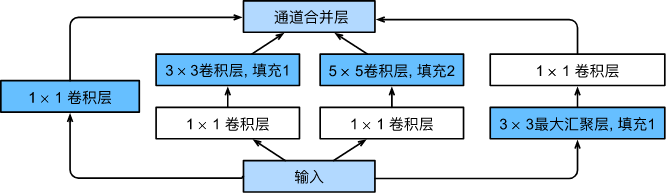


In [1]:
import torch
from torch import nn
import sys
sys.path.append("../")
from MyUtils import d2laiUtils as d2l

In [2]:
from torch.nn import functional as F
class Inception(nn.Module):
    def __init__(self, in_, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.l1 = nn.Conv2d(in_, c1, kernel_size=1)
        self.l21 = nn.Conv2d(in_, c2[0], kernel_size=1)
        self.l22 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.l31 = nn.Conv2d(in_, c3[0], kernel_size=1)
        self.l32 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.l41 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.l42 = nn.Conv2d(in_, c4, kernel_size=1)
    
    def forward(self, X):
        l1 = F.relu(self.l1(X))
        l2 = F.relu(self.l22(F.relu(self.l21(X))))
        l3 = F.relu(self.l32(F.relu(self.l31(X))))
        l4 = F.relu(self.l42(self.l41(X)))
        return torch.cat([l1, l2, l3, l4], dim=1)


Inception块有四个分支，第一个分支为1次1x1卷积，第二分支进行1次1x1卷积(激活)再进行1次3x3保真卷积(激活)，第三分支类似第二支但第二次卷积换为5x5，第四分支先进行3x3的保真最大池化再进行1次1x1的卷积。注意，这四个分支均不会对图像的宽高作出改变，因而在最后可以在dim=1也即通道维度进行合并

接下来是GoogLeNet，一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。 第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。
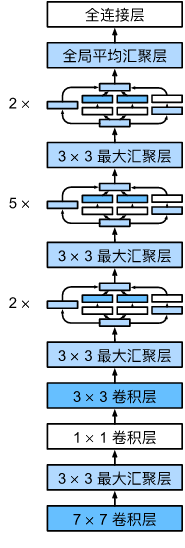

In [3]:
# 前置模块, (1, 64, 7x7, stride=2)
# (64, 64, 3x3, padding=1)(64, 192, 3x3, padding=1)
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
b2 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32), # 64+128+32+32=256
    Inception(256, 128, (128, 192), (32, 96), 64), # 128+192+96+64=480
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
b3 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64), # 192+208+48+64=512
    Inception(512, 160, (112, 224), (24, 64), 64), # 160+224+64+64=512
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
b4 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128), # 384+384+128+128=1024
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten() # [1, 1024]
)

google_net = nn.Sequential(b1, b2, b3, b4, nn.Linear(1024, 10))
google_net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Inception(
      (l1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (l21): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (l22): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (l31): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (l32): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (l41): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (l42): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))

In [4]:
X = torch.randn(1, 1, 96, 96)
for layer in google_net:
    X = layer(X)
    print(f"{layer.__class__.__name__} outshape={X.shape}")

Sequential outshape=torch.Size([1, 192, 12, 12])
Sequential outshape=torch.Size([1, 480, 6, 6])
Sequential outshape=torch.Size([1, 832, 3, 3])
Sequential outshape=torch.Size([1, 1024])
Linear outshape=torch.Size([1, 10])


loss 2.299, train acc 0.127, test acc 0.255
loss 1.850, train acc 0.325, test acc 0.579
loss 0.854, train acc 0.664, test acc 0.756
loss 0.628, train acc 0.762, test acc 0.789
loss 0.488, train acc 0.816, test acc 0.771
loss 0.427, train acc 0.840, test acc 0.827
loss 0.386, train acc 0.854, test acc 0.836
loss 0.360, train acc 0.864, test acc 0.853
loss 0.335, train acc 0.874, test acc 0.871
loss 0.315, train acc 0.881, test acc 0.873

1549.5 examples/sec on cuda:0


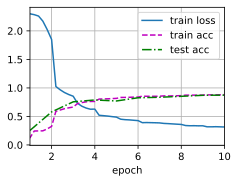

In [5]:
epoch_num, lr, batch_size, gpu = 10, 0.03, 128, torch.device("cuda:0")
train_iter, test_iter = d2l.loadFashionMnist(batch_size, 96)
d2l.train_ch6(google_net, train_iter, test_iter, epoch_num, lr, gpu)